## PID实现轨迹跟踪

假设无人车模型如下

![在这里插入图片描述](https://img-blog.csdnimg.cn/98de36e913bd4fcd86b4f3ac933b0afc.png)

In [16]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib notebook
# %matplotlib qt5
# %matplotlib auto


In [17]:
import math
class KinematicModel_3:
  """假设控制量为转向角delta_f和加速度a
  """

  def __init__(self, x, y, psi, v, L, dt):
    self.x = x
    self.y = y
    self.psi = psi
    self.v = v
    self.L = L
    # 实现是离散的模型
    self.dt = dt

  def update_state(self, a, delta_f):
    self.x = self.x+self.v*math.cos(self.psi)*self.dt
    self.y = self.y+self.v*math.sin(self.psi)*self.dt
    self.psi = self.psi+self.v/self.L*math.tan(delta_f)*self.dt
    self.v = self.v+a*self.dt

  def get_state(self):
    return self.x, self.y, self.psi, self.v




导入PID控制器

In [18]:


from PID_controller import PID_posi_2,PID_inc
## 位置式
PID = PID_posi_2(k=[2, 0.025, 20], target=0, upper=np.pi/6, lower=-np.pi/6)
## 增量式
# PID = PID_inc(k=[1, 1, 15], target=0, upper=np.pi/6, lower=-np.pi/6)



KDTree说明
参考[资料](https://www.cnblogs.com/yibeimingyue/p/13797529.html#:~:text=%E7%94%A8%E6%B3%95%EF%BC%9A%20KDTree.query%28self%2C%20x%2C%20k%3D1%2C%20eps%3D0%2C%20p%3D2%2C%20distance_upper_bound%3Dinf%29%20%E6%9F%A5%E8%AF%A2kd-tree%E9%99%84%E8%BF%91%E7%9A%84%E9%82%BB%E5%B1%85,x%EF%BC%9Aarray_like%20python%20scipy%20spatial.KDTree.query%E7%94%A8%E6%B3%95%E5%8F%8A%E4%BB%A3%E7%A0%81%E7%A4%BA%E4%BE%8B%20-%20%E4%B8%80%E6%9D%AF%E6%98%8E%E6%9C%88%20-%20%E5%8D%9A%E5%AE%A2%E5%9B%AD)

KDTree在这里的作用是用于搜索最临近的航路点

这部分的功能也可以使用以下函数实现

In [19]:
def cal_target_index(robot_state,refer_path):
    """得到临近的路点

    Args:
        robot_state (_type_): 当前车辆位置
        refer_path (_type_): 参考轨迹（数组）

    Returns:
        _type_: 最近的路点的索引
    """
    dists = []
    for xy in refer_path:
        dis = np.linalg.norm(robot_state-xy)
        dists.append(dis)

    min_index = np.argmin(dists)
    return min_index

主函数

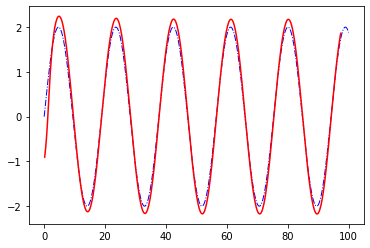

In [20]:
from scipy.spatial import KDTree

# set reference trajectory
refer_path = np.zeros((1000, 2))
refer_path[:,0] = np.linspace(0, 100, 1000) # 直线
refer_path[:,1] = 2*np.sin(refer_path[:,0]/3.0)#+2.5*np.cos(refer_path[:,0]/2.0) # 生成正弦轨迹
refer_tree = KDTree(refer_path)  # reference trajectory
plt.figure(1)
# plt.axis([0,18,-3, 3])
plt.plot(refer_path[:,0], refer_path[:,1], '-.b', linewidth=1.0)


# 假设初始状态为x=0,y=-1,偏航角=0.5rad，前后轴距离2m，速度为2m/s，时间步为0.1秒
ugv = KinematicModel_3(0,-1,0.5,2,2,0.1)
k=0.1
c=2
pind=0
ind = 0
x_ = []
y_ = []
for i in range(550):
    robot_state = np.zeros(2)
    robot_state[0] = ugv.x
    robot_state[1] = ugv.y
    distance, ind = refer_tree.query(robot_state) # 在参考轨迹上查询离robot_state最近的点
    # ind = cal_target_index(robot_state,refer_path)  # 使用简单的一个函数实现查询离robot_state最近的点，耗时比较长
    if ind < pind:
        ind = pind
    else:
        pind = ind

    alpha = math.atan2(refer_path[ind, 1]-robot_state[1], refer_path[ind, 0]-robot_state[0])
    l_d = np.linalg.norm(refer_path[ind]-robot_state)
    # l_d = k*ugv.v+c  # 前视距离
    theta_e = alpha-ugv.psi
    e_y = -l_d*math.sin(theta_e)  # 与博客中公式相比多了个负号，我目前还不是太理解，暂时先放着
    # e_y = -l_d*np.sign(math.sin(theta_e))  # 第二种误差表示
    # e_y = robot_state[1]-refer_path[ind, 1] #第三种误差表示
    # PID.set_target(0)
    # print(refer_path[i,1])
    delta_f = PID.cal_output(e_y)
    # print(e_y)
    # print(alpha)
    ugv.update_state(0,delta_f) # 加速度设为0

    x_.append(ugv.x)
    y_.append(ugv.y)
plt.plot(x_,y_,'r')
plt.show()
